In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand
from scipy.optimize import curve_fit
from scipy import integrate
from statsmodels.graphics.tsaplots import plot_acf

# Prelab 6 - OT
Hamish Johnson Feb 4, 2022

## Monte Carlo Simulation

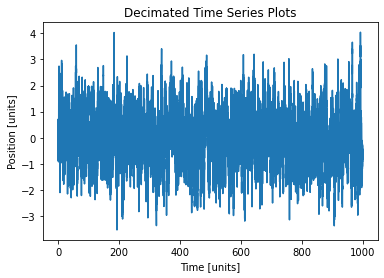

In [ ]:
k = 1
gamma = 1
tau_0 = k/gamma
deltaT = 0.01
D = 1 #= kB T / gamma
c = np.exp(-deltaT/tau_0)
s = np.sqrt((1-c**2)*D*tau_0)

def mapFxn(xn, c, s, epsilon):
    return xn*c + s*epsilon

N = 10**5
x0 = 0

def linearSim(x0, c, s, N):
    t_sim = np.arange(0,N*deltaT,deltaT)
    x_sim = [x0]
    for _ in range(N-1):
        epsilon = rand.normal(0,1)
        xn = x_sim[-1]
        x_new = mapFxn(xn, c, s, epsilon)
        x_sim.append(x_new)
    return t_sim, x_sim

t, x = linearSim(x0, c, s, N)


plt.plot(t,x)
plt.title("Decimated Time Series Plots")
plt.ylabel("Position [units]")
plt.xlabel("Time [units]")
plt.show()


## Data Analysis

### a) variance

In [ ]:
var = np.var(x)
std = np.std(x)
if std**2 == var:
    print("(:")

print("Variance =", np.around(var,3))
print("Which is compatible with the std of 1 that we initiated the random seed with. And since we expect it to equal D*tau_0 = 1.")

(:
Variance = 0.995
Which is compatible with the std of 1 that we initiated the random seed with. And since we expect it to equal D*tau_0 = 1.


### B) Autocorrelation

Decays to about 1/e after 100 steps -> We would want to decimate by ~100


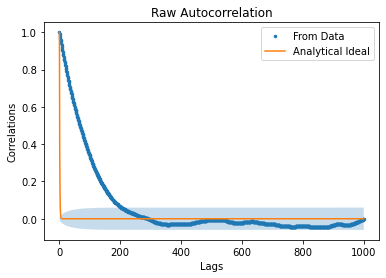

In [ ]:
# Plot experimental autocorrelation
plot_acf(np.array(x),lags = 1000,label = "From Data",marker = ".",use_vlines=False);

plt.plot(t,D*tau_0*np.exp(-np.abs(t)/tau_0),label = "Analytical Ideal")
plt.legend()
plt.title("Raw Autocorrelation")
plt.ylabel("Correlations")
plt.xlabel("Lags")

print("Decays to about 1/e after 100 steps -> We would want to decimate by ~100")


### c) Histogram Analysis

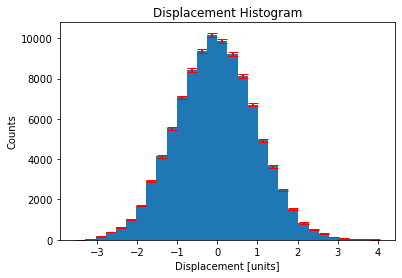

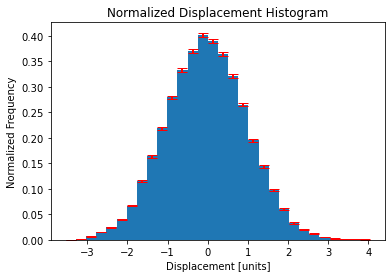

In [ ]:
# Plot histogram
nbins = 30
counts, bins, _ = plt.hist(x,bins = nbins)
# sqrt estimate of errors
err = np.sqrt(counts)
# Nromalizing constant
norm = np.sum(counts)*np.diff(bins)[0]

# Plot histogram
plt.errorbar((1/2)*(bins[:-1]+bins[1:]), counts, yerr = err, fmt="o",color = "Red",markersize = 0,elinewidth = 2,capsize = 5)
plt.title("Displacement Histogram")
plt.ylabel("Counts")
plt.xlabel("Displacement [units]")
plt.show()

# Normalize and plot
counts, bins, _ = plt.hist(x,bins = nbins,density = True)
# sqrt estimate of errors
err *= 1/norm
plt.errorbar((1/2)*(bins[:-1]+bins[1:]), counts, yerr = err, fmt="o",color = "Red",markersize = 0,elinewidth = 2,capsize = 5)
plt.title("Normalized Displacement Histogram")
plt.ylabel("Normalized Frequency")
plt.xlabel("Displacement [units]")
plt.show()



### d) Fit Distribution

Using a 2 parameter gaussian fit because we are only fitting mu and sigma since are not fitting the amplitude of the peak or any offsets
Optimized fit parameters
mu 	= -0.0347 +/- 0.00316 [units]
sigma 	= 0.997 +/- 0.00224 [units]


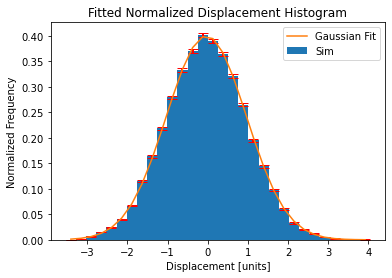

Fit Statistics
 ChiSq 		= 134.54183 +/- 7.48331
 nu 		= 28
 Reduced Chi 	= 4.80507
chi squared is a factor of 7 too large


In [ ]:
# Model PDF
def gaussianModel(x, mu, sigma):
    return np.exp((-(x-mu)**2)/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))
print("Using a 2 parameter gaussian fit because we are only fitting mu and sigma since are not fitting the amplitude of the peak or any offsets")

counts, bins, _ = plt.hist(x,bins = nbins,density = True,label = "Sim")
x_dat = (1/2)*(bins[:-1]+bins[1:])
y_dat = counts

p_0 = [1,2] # lets make the fit work for it a little

pOpt, pCov = curve_fit(gaussianModel, x_dat, y_dat, p0 = p_0, sigma = err, absolute_sigma = True)

mu_opt = pOpt[0]
sigma_opt = pOpt[1]
mu_err = np.sqrt(pCov[0][0])
sigma_err = np.sqrt(pCov[1][1])

dec = 5
print("Optimized fit parameters")
print("mu \t=",np.around(mu_opt,dec),"+/-",np.around(mu_err,dec),"[units]")
print("sigma \t=",np.around(sigma_opt,dec),"+/-",np.around(sigma_err,dec),"[units]")

# Plot Data
plt.errorbar(x_dat, y_dat, yerr = err, fmt="o",color = "Red",markersize = 0,elinewidth = 2,capsize = 5)
# Plot Fit
model = np.linspace(np.min(x_dat),np.max(x_dat),len(x_dat))
plt.plot(x_dat,gaussianModel(x_dat,mu_opt,sigma_opt),label = "Gaussian Fit")
plt.title("Fitted Normalized Displacement Histogram")
plt.ylabel("Normalized Frequency")
plt.xlabel("Displacement [units]")
plt.legend()
plt.show()


# Calculate Residuals
res = y_dat - gaussianModel(x_dat,mu_opt,sigma_opt)
normRes = res/err

# Calculate Chi squared statistics
N = len(x_dat)
chiSq = np.sum(normRes**2)
nu = N  - len(pOpt) # points minus #fit parameters
chiSigma = np.sqrt(2*nu)
print("Fit Statistics\n ChiSq \t\t=",np.around(chiSq,dec),"+/-",np.around(chiSigma,dec))
print(" nu \t\t=",nu)
print(" Reduced Chi \t=",np.around(chiSq/nu,dec))
print("chi squared is a factor of 7 too large")

### e) Decimated Time Plot

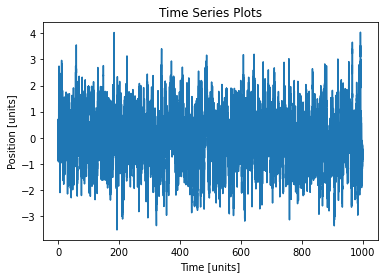

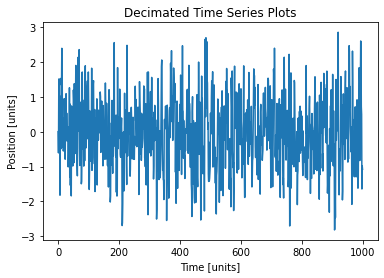

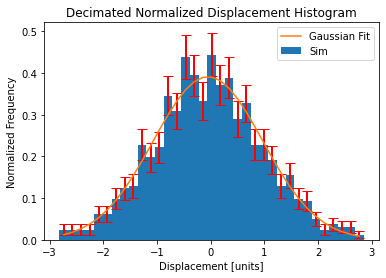

Optimized fit parameters
mu 	= -0.04979 +/- 0.03282 [units]
sigma 	= 1.01978 +/- 0.02619 [units]
Fit Statistics
 ChiSq 		= 23.1711 +/- 8.12404
 nu 		= 33
 Reduced Chi 	= 0.70215
Now Chi Squared is of right scale!!! (:


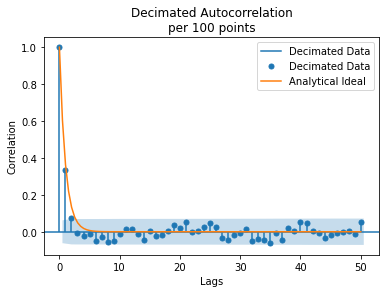

In [ ]:
interval = 100 # In order to get one point per Tc = tau_0 = 1 therefore with 0.01 timesteps we need a factor of 100 cut
t_dec = t[::interval]
x_dec = x[::interval]

plt.plot(t,x,label="Old")
plt.title("Time Series Plots")
plt.ylabel("Position [units]")
plt.xlabel("Time [units]")
plt.show()

plt.plot(t_dec,x_dec)
plt.title("Decimated Time Series Plots")
plt.ylabel("Position [units]")
plt.xlabel("Time [units]")
plt.show()

nbins = 35
counts, bins, _ = plt.hist(x_dec,bins = nbins,label = "Sim")
plt.clf()
# sqrt estimate of errors
err = np.sqrt(counts)
# Nromalizing constant
norm = np.sum(counts)*np.diff(bins)[0]
counts, bins, _ = plt.hist(x_dec,bins = nbins,density = True,label = "Sim")
# Normalized data, errors with 0's filtered out to avoid fitting errors
y_dat = counts[counts!=0]
x_dat = (1/2)*(bins[:-1]+bins[1:])[counts!=0]
err = err[counts!=0]/norm

p_0 = [0,1]

pOpt, pCov = curve_fit(gaussianModel, x_dat, y_dat, p0 = p_0, sigma = err, absolute_sigma = True)
mu_opt = pOpt[0]
sigma_opt = pOpt[1]
mu_err = np.sqrt(pCov[0][0])
sigma_err = np.sqrt(pCov[1][1])

dec = 5

# Plot Data
plt.errorbar(x_dat, y_dat, yerr = err, fmt="o",color = "Red",markersize = 0,elinewidth = 2,capsize = 5)
# Plot Fit
model = np.linspace(np.min(x_dat),np.max(x_dat),len(x_dat))
plt.plot(x_dat,gaussianModel(x_dat,mu_opt,sigma_opt),label = "Gaussian Fit")
plt.title("Decimated Normalized Displacement Histogram")
plt.ylabel("Normalized Frequency")
plt.xlabel("Displacement [units]")
plt.legend()
plt.show()

# Now lets get fit statistics
# Calculate Residuals
res = y_dat - gaussianModel(x_dat,mu_opt,sigma_opt)
normRes = res/err

# Calculate Chi squared statistics
N = len(x_dat)
chiSq = np.sum(normRes**2)
nu = N  - pOpt.size # points minus #fit parameters
chiSigma = np.sqrt(2*nu)

print("Optimized fit parameters")
print("mu \t=",np.around(mu_opt,dec),"+/-",np.around(mu_err,dec),"[units]")
print("sigma \t=",np.around(sigma_opt,dec),"+/-",np.around(sigma_err,dec),"[units]")
print("Fit Statistics\n ChiSq \t\t=",np.around(chiSq,dec),"+/-",np.around(chiSigma,dec))
print(" nu \t\t=",nu)
print(" Reduced Chi \t=",np.around(chiSq/nu,dec))
print("Now Chi Squared is of right scale!!! (:")

autocorr_max_x = 50
model = np.linspace(0,autocorr_max_x,100)
plot_acf(np.array(x_dec),lags = autocorr_max_x,label = "Decimated Data");
plt.plot(model,D*tau_0*np.exp(-np.abs(model)/tau_0),label = "Analytical Ideal")
plt.title("Decimated Autocorrelation\nper " + str(interval) +" points")
plt.ylabel("Correlation")
plt.xlabel("Lags")
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4bb45f9e-f9d7-4771-843d-2a6451217511' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>